In [9]:
import pandas as pd
import numpy as np
import glob
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [10]:
fp_data = "../results/bothterms_metrics_SM/"
FNs = glob.glob(fp_data+"*.tsv")
df_results = pd.DataFrame()
for aFN in FNs:
    df_tmp = pd.read_csv(aFN,sep="\t")
    df_tmp["Train"] = df_tmp["method"].tolist()[0].split("-")[2]
    df_tmp["Test"] = df_tmp["method"].tolist()[0].split("-")[4]
    df_tmp["AddGenes"] = df_tmp["method"].tolist()[0].split("-")[0]
    df_results = pd.concat([df_results,df_tmp])
df_results.head()

,GSC_info,method,network,species,connections,feature_type,model_info,ID,name,num_train_pos,num_train_all,num_test_pos,num_test_all,avgp,log2p,auroc,PTopK,Train,Test,AddGenes
0,dm_hs__15_200_0.5_0.5,PosNeg-Trn-dm_hs-Tst-hs,IMP_raw,ce_dm_dr_hs_mm_sc,eggnog_direct_SummedDegree-0.50,Pecanpy_2000_DenseOTF_0.1_0.001_120_8_10_weigh...,NoScaling__LR_l2_1.0,GO:0001578,microtubule bundle formation,35,12136,30,4174,0.060792,3.080354,0.871726,3,dm_hs,hs,PosNeg
1,dm_hs__15_200_0.5_0.5,PosNeg-Trn-dm_hs-Tst-hs,IMP_raw,ce_dm_dr_hs_mm_sc,eggnog_direct_SummedDegree-0.50,Pecanpy_2000_DenseOTF_0.1_0.001_120_8_10_weigh...,NoScaling__LR_l2_1.0,GO:0002520,immune system development,219,12072,13,4174,0.002988,-0.059856,0.462592,0,dm_hs,hs,PosNeg
2,dm_hs__15_200_0.5_0.5,PosNeg-Trn-dm_hs-Tst-hs,IMP_raw,ce_dm_dr_hs_mm_sc,eggnog_direct_SummedDegree-0.50,Pecanpy_2000_DenseOTF_0.1_0.001_120_8_10_weigh...,NoScaling__LR_l2_1.0,GO:0006302,double-strand break repair,149,12107,23,4174,0.076534,3.795890,0.845422,5,dm_hs,hs,PosNeg
3,dm_hs__15_200_0.5_0.5,PosNeg-Trn-dm_hs-Tst-hs,IMP_raw,ce_dm_dr_hs_mm_sc,eggnog_direct_SummedDegree-0.50,Pecanpy_2000_DenseOTF_0.1_0.001_120_8_10_weigh...,NoScaling__LR_l2_1.0,GO:0006310,DNA recombination,104,12117,23,4174,0.114157,4.372750,0.805579,4,dm_hs,hs,PosNeg
4,dm_hs__15_200_0.5_0.5,PosNeg-Trn-dm_hs-Tst-hs,IMP_raw,ce_dm_dr_hs_mm_sc,eggnog_direct_SummedDegree-0.50,Pecanpy_2000_DenseOTF_0.1_0.001_120_8_10_weigh...,NoScaling__LR_l2_1.0,GO:0006399,tRNA metabolic process,83,12141,54,4174,0.246458,4.251739,0.934295,14,dm_hs,hs,PosNeg


In [11]:
def make_plot4(network, features, task, figname):
    
    convert_dict = {"ce":"worm","dm":"fly","mm":"mouse","sc":"yeast","hs":"human"}
    
    if task == "mdl":
        myspecies = [["mm","hs_mm","hs"],["dm","dm_hs","hs"],["ce","ce_hs","hs"],["sc","hs_sc","hs"]]
    elif task == "human":
        myspecies = [["hs","hs_mm","mm"],["hs","dm_hs","dm"],["hs","ce_hs","ce"],["hs","hs_sc","sc"]]
    
    fig, ax = plt.subplots(1,4,figsize=(14,6))
    for idx, item in enumerate(myspecies):
        df_tmp = df_results[(df_results["network"]==network)&
                            (df_results["feature_type"].str.contains(features))&
                            (df_results["AddGenes"]=="cross")&
                            (df_results["GSC_info"].str.contains(item[1]))&
                            (df_results["Test"]==item[0])]
        sns.boxplot(data=df_tmp,y="log2p",x="Train",hue="species",notch=True,showfliers=False,ax=ax[idx],
        palette=["red","blue"],hue_order=[item[1],"ce_dm_dr_hs_mm_sc"],order=[item[0],item[2]])
        ax[idx].legend(loc=2,title="TrnGenes")
        if idx == 0:
            ax[idx].set_ylabel("log2(auPRC/prior)",fontsize=10)
        else:
            ax[idx].set_ylabel("")
        ax[idx].set_xlabel("Genes Used in Training",fontweight="bold")
        if task == 'mdl':
            ax[idx].set_xticklabels([convert_dict[item[0]],"human"])
            handles, labels = ax[idx].get_legend_handles_labels()
            ax[idx].legend(handles,[f"{convert_dict[item[0]]}-human","All-species"],
                           loc=2,title="Model Features")
        elif task == "human":
            ax[idx].set_xticklabels(["human",convert_dict[item[2]]])
            handles, labels = ax[idx].get_legend_handles_labels()
            ax[idx].legend(handles,[f"human-{convert_dict[item[2]]}","All-species"],
                           loc=2,title="Model Features")
    network2 = network.split("_")[0]
    if task == "mdl":
        fig.suptitle(f"Model Species Annotation Prediction - Network: {network2}",fontweight="bold",
                     fontsize=14,y=0.98)
    else:
        fig.suptitle(f"Human Annotation Prediction - Network: {network2}",fontweight="bold",
                     fontsize=14,y=0.98)        
    plt.tight_layout()
    fig.subplots_adjust(wspace=0.2,top=0.9)
    fig.savefig(f"../figures/{figname}")

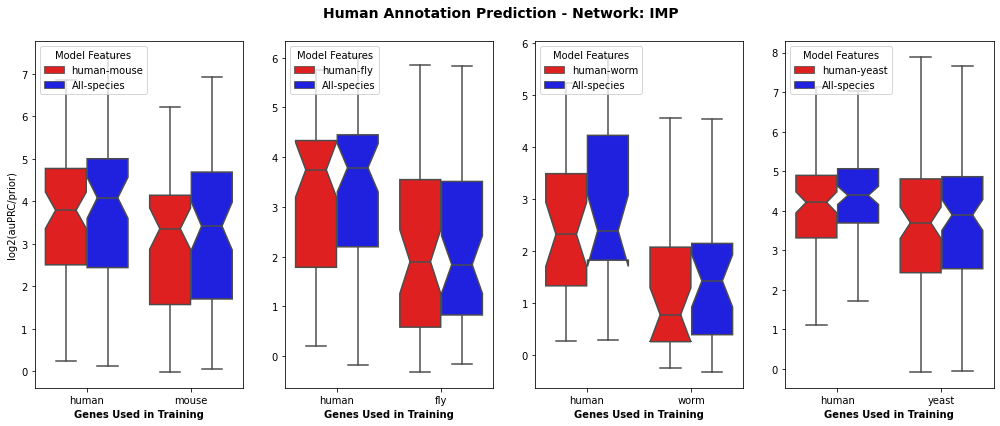

In [12]:
make_plot4("IMP_raw","Pecanpy","human","FigSM10.pdf")

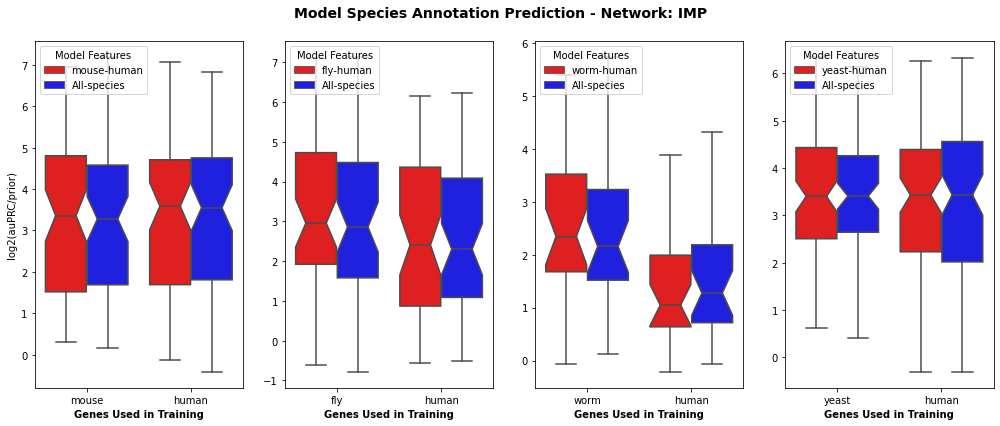

In [13]:
make_plot4("IMP_raw","Pecanpy","mdl","FigSM11.pdf")

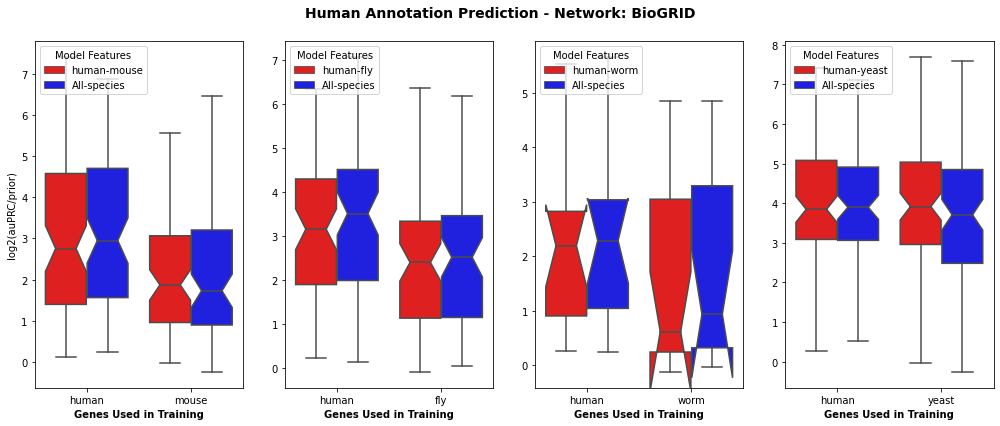

In [14]:
make_plot4("BioGRID_raw","Pecanpy","human","FigSM12.pdf")

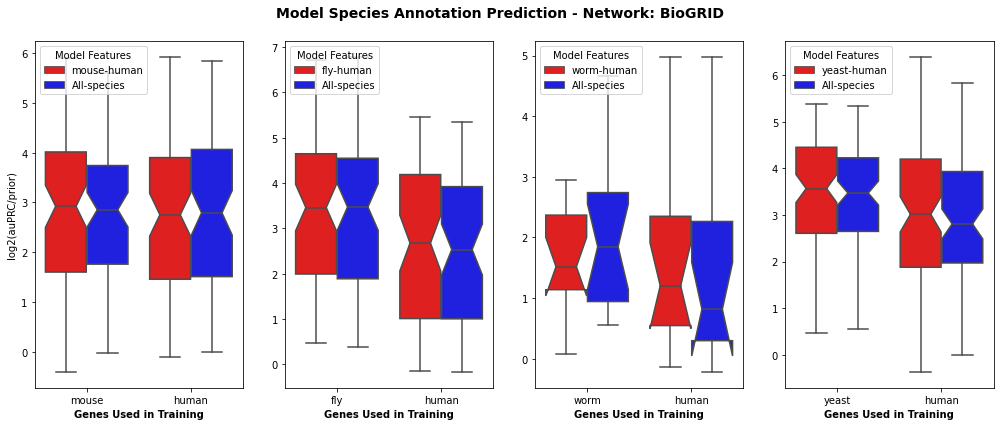

In [15]:
make_plot4("BioGRID_raw","Pecanpy","mdl","FigSM13.pdf")